<a href="https://colab.research.google.com/github/McyRoyAl/data_processing/blob/main/signal_image%26data_proc_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import sin, cos, pi, sqrt, log, exp, ceil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
def array_to_image(a, size=512):
  """Utility function for printing an array as an image"""
  return Image.fromarray(np.clip((a - np.min(a)) / (np.max(a) - np.min(a)) * 256, 1, 255) \
                         .astype(np.uint8)) \
              .resize((size, size), resample=0)

# 1. Numerical and Practical Bit Allocation for Two-Dimensional Signals


Consider a function,

    φ(x, y) = A cos(2πωx) sin(2πωy) for (x, y) ∈ [0, 1] × [0, 1]

In [ ]:
A = 2500
w = np.array((2, 7))
f = lambda x, y: A * cos(2 * pi * w[0] * x) * sin(2 * pi * w[1] * y)

## Theory

Mathematically develop formulas for derivatives and integrals to calculate the value-range, the horizontal-derivative energy and the vertical-derivative energy.

Since the value range of `cos` and `sin` are `[-1, 1]`, the value range of the formula is `[-A, A]` which is size `2A`.

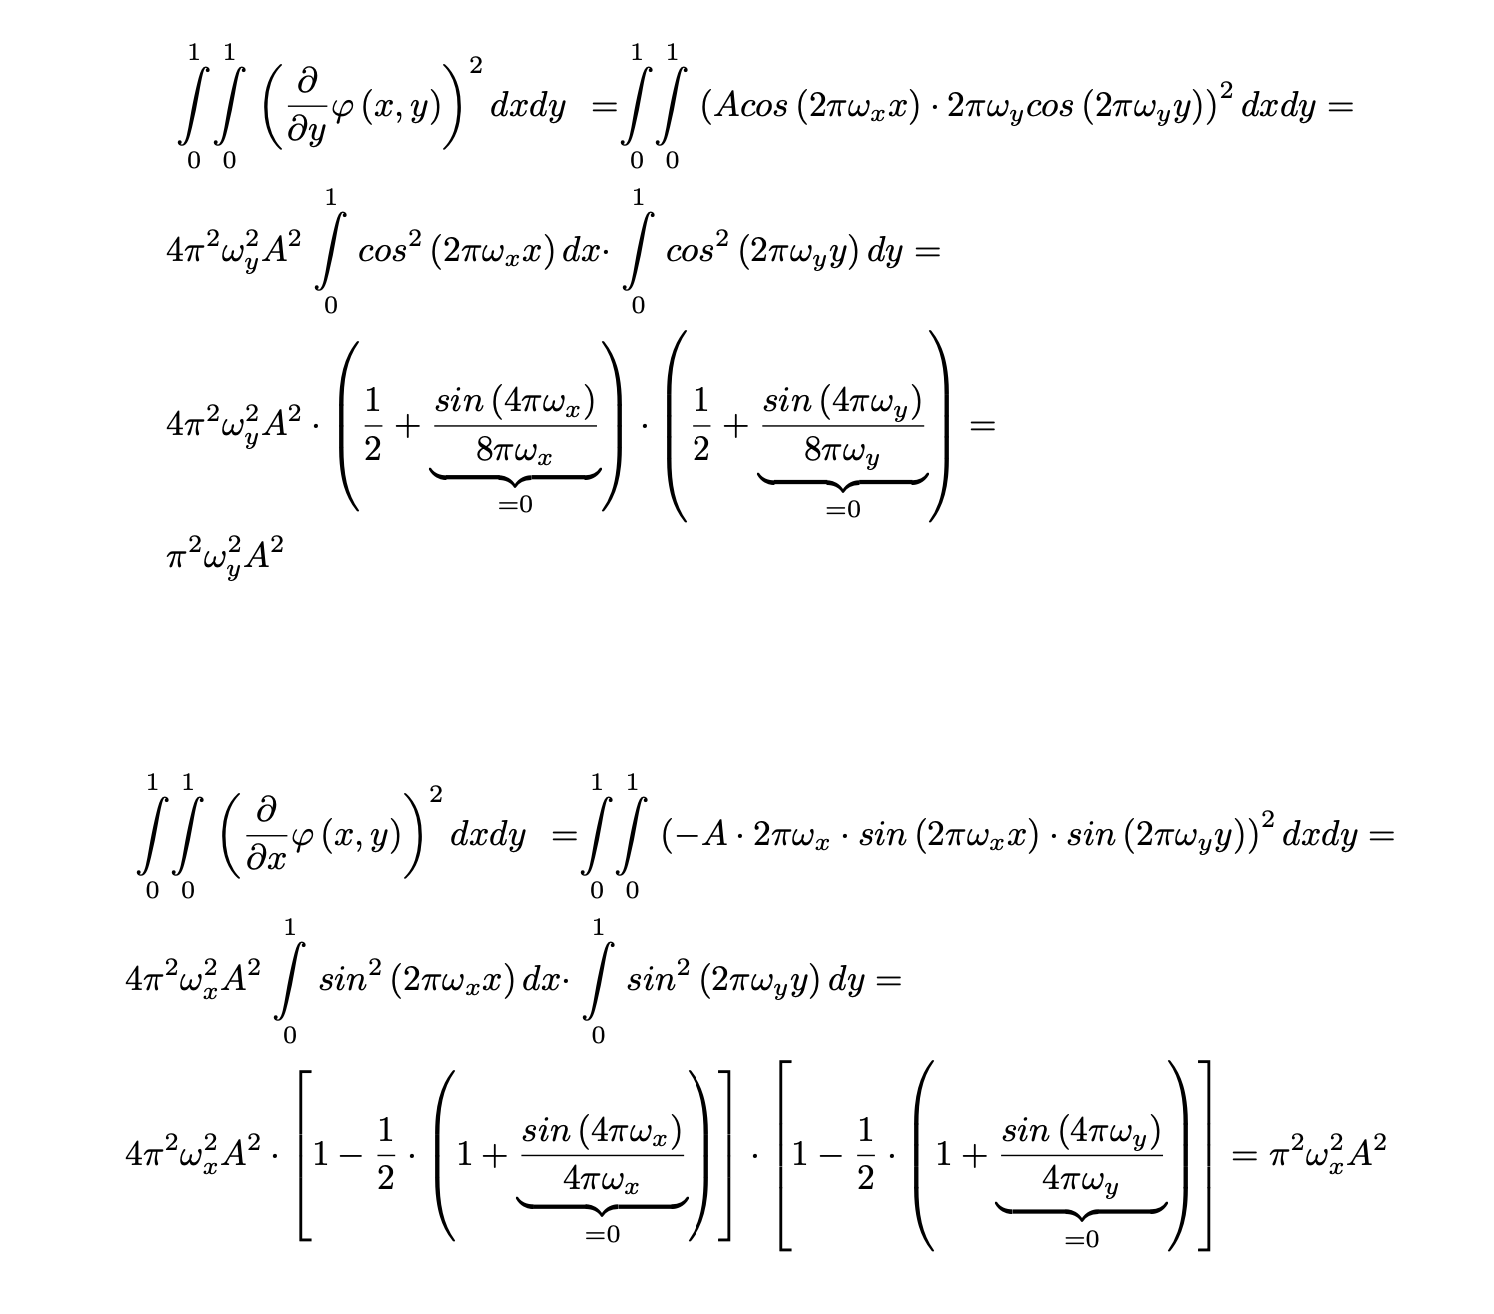

## Application


Approximate the continuous-domain signal φ(x, y) by a very high resolution digitalization. Present the signal as an image using the cv2.imshow function (use an appropriate gray-level scaling that suits the value of A).

In [ ]:
def F(x1, y1, x2, y2):
  """Returns the average value of f(x, y) in a 2-d range (using the integral)"""
  return A / (4 * pi * pi * w[0] * w[1] * (x2 - x1) * (y2 - y1)) \
           * (sin(2 * pi * w[0] * x2) - sin(2 * pi * w[0] * x1)) \
           * (cos(2 * pi * w[1] * y1) - cos(2 * pi * w[1] * y2))

In [ ]:
def sample(integral, shape):
  i, j = np.mgrid[:shape[0], :shape[1]]
  return np.vectorize(integral)(i / shape[0], j / shape[1], (i + 1) / shape[0], (j + 1) / shape[1])

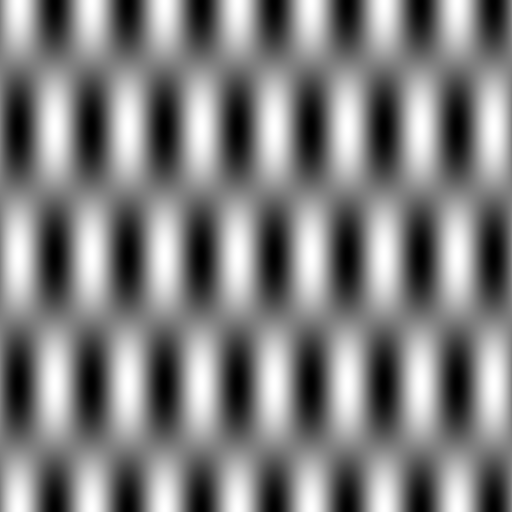

In [ ]:
a = sample(F, (512, 512))
display(array_to_image(a))  # This is better than cv2.imshow

Numerically calculate the value-range, the horizontal-derivative energy and the vertical-derivative energy. Compare these numerical results to the analytically calculated values from the question a.

In [ ]:
vrange = np.max(a) - np.min(a)

energy = np.array((
    np.sum(np.square(np.diff(a, axis=0))) * pow(a.shape[0] / a.shape[1], 2),
    np.sum(np.square(np.diff(a, axis=1))) * pow(a.shape[1] / a.shape[0], 2)
  ))

print(f"Exact value range: {2 * A}")
print(f"Approximate value range: {vrange}\n")

print(f"Exact horizontal-derivative energy: {pow(A * pi * w[0], 2)}")
print(f"Approximate horizontal-derivative energy: {energy[0]}\n")

print(f"Exact vertical-derivative energy: {pow(A * pi * w[1], 2)}")
print(f"Approximate vertical-derivative energy: {energy[1]}")

Exact value range: 5000
Approximate value range: 4997.8668752656495

Exact horizontal-derivative energy: 246740110.02723396
Approximate horizontal-derivative energy: 246563660.2512484

Exact vertical-derivative energy: 3022566347.833616
Approximate vertical-derivative energy: 3006907658.122702


The approximate range is slightly smaller than the exact value because the maxima and minima are smoothed. The same thing can be observed in the derivative energies.

Use the numerical approximations and numerically solve the bit-allocation optimization to determine N_x, N_y and b.

In [ ]:
def allocate(B, vrange, energy):
  b = log(B * vrange * vrange * log(2) / sqrt(np.product(energy)), 4)
  N = np.sqrt((B / b) * np.sqrt(energy / np.flip(energy)))
  return N, b

Consider two bit-allocation procedures with the bit-budgets B_low = 5000 and B_high = 50000. Write the obtained values of N_x, N_y and b.

In [ ]:
def MSE(N, b, vrange, energy):
  return (np.sum(energy / np.square(N)) + (vrange * vrange / pow(4, b))) / 12

In [ ]:
B_low = 5000
N, b = allocate(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}\n")

B_high = 50000
N, b = allocate(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")

Bit allocation for B = 5000:
N_x = 20.74857100903572
N_y = 72.45755960335755
b = 3.3258151716654916
MSE = 116159.30050496734

Bit allocation for B = 50000:
N_x = 53.58301860736825
N_y = 187.12106789332276
b = 4.986779219109173
MSE = 16383.132078008275


## Optimizing Bit-Allocation Parameters

Implement a searching procedure that finds the best bit-allocation parameters by practically evaluating the bit-allocation MSE for many combinations of parameters.

In [ ]:
def optimize(B, vrange, energy, max_step=12):
  """Find the globally optimal bit allocation by taking incrementally growing steps"""
  E = lambda N, b: MSE(N, b, vrange, energy)
  N, b = np.array((1, 1)), 1  # initial guess

  def increment(N, b, d):
    """Find the best bit allocation within Chebyshev distance d"""
    N_next, b_next = N, b
    neighbors = np.reshape(np.transpose(np.mgrid[-d: d + 1, -d: d + 1, -d: d + 1],
                                        (3, 2, 1, 0)), (pow(2 * d + 1, 3), 3))
    neighbors = neighbors[np.max(np.abs(neighbors), axis=1) == d]  # remove already done ones
    for neighbor in neighbors:
      N_try, b_try = np.maximum(N + neighbor[:2], 1), max(b + neighbor[2], 1)
      if (np.product(N_try) * b_try <= B) and E(N_try, b_try) < E(N_next, b_next):
        N_next, b_next = N_try, b_try
    return N_next, b_next

  N_next, b_next = N, b,
  while True:
    step = 1
    while (N_next == N).all() and b_next == b:
      if step > max_step:
        return N, b
      N_next, b_next = increment(N, b, step)
      step += 1
    # print(N_next, b_next, E(N_next, b_next), step - 1)
    N, b = N_next, b_next

Apply the practical searching procedure for two bit-budgets B_low = 5000 and B_high = 50000. For each of the two bit-budgets, what are the optimal values of Nx, Ny and b? Are these similar to the corresponding values from the question e? Explain it in detail. Present the reconstructed images obtained in the experiments.

In [ ]:
B_low = 5000
N, b = optimize(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}\n")

B_high = 50000
N, b = optimize(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")

Bit allocation for B = 5000:
N_x = 21
N_y = 79
b = 3
MSE = 119266.00472091335

Bit allocation for B = 50000:
N_x = 54
N_y = 185
b = 5
MSE = 16400.477354325478


These values are similar but not exactly the same to those found analytically. Because the analytic method is not guaranteed to return an integer, the closest integral solution must have a slightly higher MSE than the ideal.

Reconstruct the image:

In [ ]:
def apply_quantization(array, d, r):
  quantized = np.ones(array.shape) * r[-1]
  for i in range(len(r)):
    quantized[(d[i] <= array) & (array < d[i + 1])] = r[i]
  return quantized

def quantization_error(array, d, r):
  """Calculates the quantization error given the pixel distribution, decision and representation levels."""
  return np.sum(np.square(array - apply_quantization(array, d, r)) / np.product(array.shape))

def uniform_quantization(array, bits):
  """Calculates the decision and representation levels for a uniform quantization using b bits."""
  d = np.arange((1 << bits) + 1) / (1 << bits) * (np.max(array) - np.min(array)) + np.min(array)
  r = (d[:-1] + d[1:]) / 2
  return d, r

def max_lloyd_update(array, d, r):
  """Helper function for Max-Lloyd quantization."""
  r_next = np.empty(r.shape)
  for i in range(len(r)):
    x = array[(d[i] <= array) & (array < d[i + 1])]
    r_next[i] = np.sum(x) / np.product(x.shape) if np.product(x.shape) else (d[i] + d[i + 1]) / 2
  d_next = np.copy(d)
  d_next[1:-1] = (r_next[1:] + r_next[:-1]) / 2
  return d_next, r_next

def max_lloyd_quantization(array, bits, epsilon=0.001):
  """Executes Max-Lloyd quantization algorithm for b bits with a convergence threshold of epsilon."""
  d, r = uniform_quantization(array, bits)  # start with a uniform quantization
  e = quantization_error(array, d, r)
  delta = epsilon
  while abs(delta) >= epsilon:  # loop until difference is less than the threshold
    d, r = max_lloyd_update(array, d, r)  # update decision and representation levels
    delta = e - quantization_error(array, d, r)
    e = e - delta  # recalculate error
  return d, r

def quantize(array, algorithm, bits):
  """Returns a quantized version of the input image using the provided algorithm."""
  d, r = algorithm(array, bits)
  return apply_quantization(array, d, r)

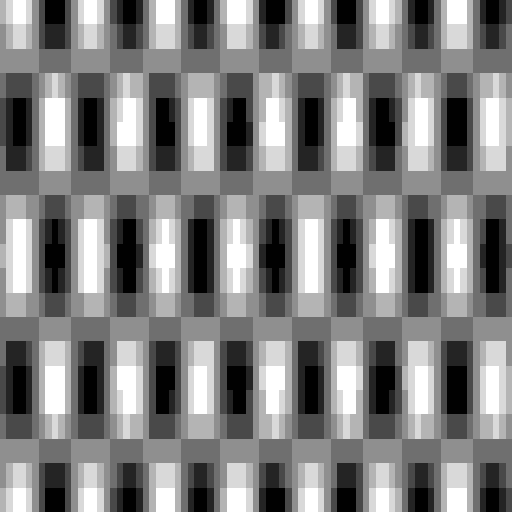

In [ ]:
N, b = optimize(B_low, vrange, energy)
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

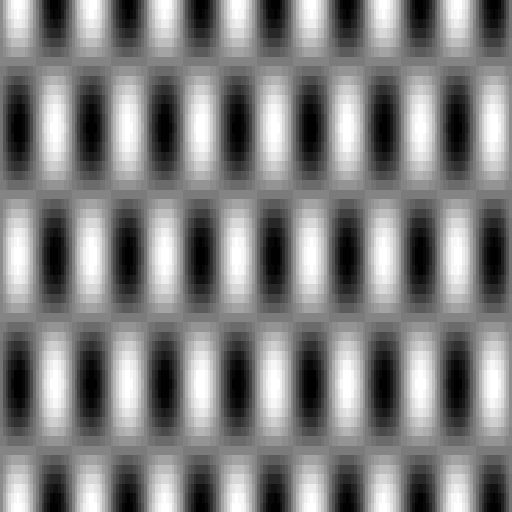

In [ ]:
N, b = optimize(B_high, vrange, energy)
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

## Repeat Analysis for Different Parameters

Consider the same function but with different parameters: A = 2500, ωx = 7 and
ωy = 2. Repeat the analysis from question a to question g and compare the results.
Explain the differences.

As can be seen in the picture and in the results below, every value is the same as in the previous function but where the x and y axes are switched.

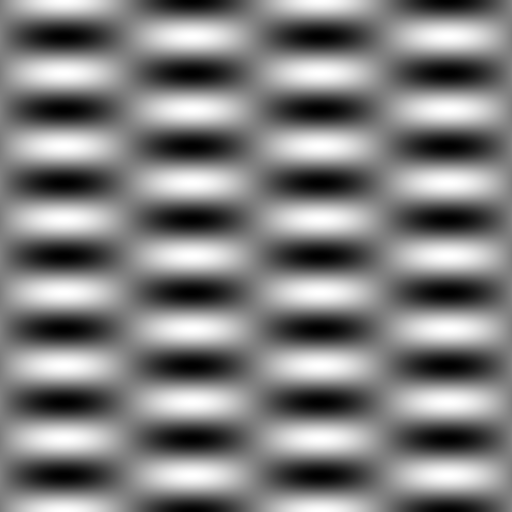

In [ ]:
w = np.array((7, 2))
a = sample(F, (512, 512))
display(array_to_image(a))

In [ ]:
vrange = np.max(a) - np.min(a)

energy = np.array((
    np.sum(np.square(np.diff(a, axis=0))) * pow(a.shape[0] / a.shape[1], 2),
    np.sum(np.square(np.diff(a, axis=1))) * pow(a.shape[1] / a.shape[0], 2)
  ))

print(f"Exact value range: {2 * A}")
print(f"Approximate value range: {vrange}\n")

print(f"Exact horizontal-derivative energy: {pow(A * pi * w[0], 2)}")
print(f"Approximate horizontal-derivative energy: {energy[0]}\n")

print(f"Exact vertical-derivative energy: {pow(A * pi * w[1], 2)}")
print(f"Approximate vertical-derivative energy: {energy[1]}")

Exact value range: 5000
Approximate value range: 4997.86687526565

Exact horizontal-derivative energy: 3022566347.833616
Approximate horizontal-derivative energy: 3018699452.8604403

Exact vertical-derivative energy: 246740110.02723396
Approximate vertical-derivative energy: 245600520.95339188


In [ ]:
B_low = 5000
N, b = allocate(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}\n")

B_high = 50000
N, b = allocate(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")

Bit allocation for B = 5000:
N_x = 72.59949423419609
N_y = 20.708006804041474
b = 3.3258151716654916
MSE = 116159.30050496735

Bit allocation for B = 50000:
N_x = 187.4876129417475
N_y = 53.47826187255247
b = 4.986779219109173
MSE = 16383.13207800828


Bit allocation for B = 5000:
N_x = 79
N_y = 21
b = 3
MSE = 119241.45626823658


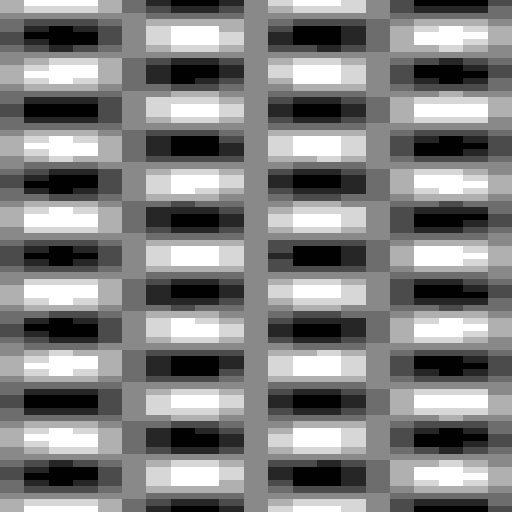

In [ ]:
B_low = 5000
N, b = optimize(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

Bit allocation for B = 50000:
N_x = 185
N_y = 54
b = 5
MSE = 16401.664252757193


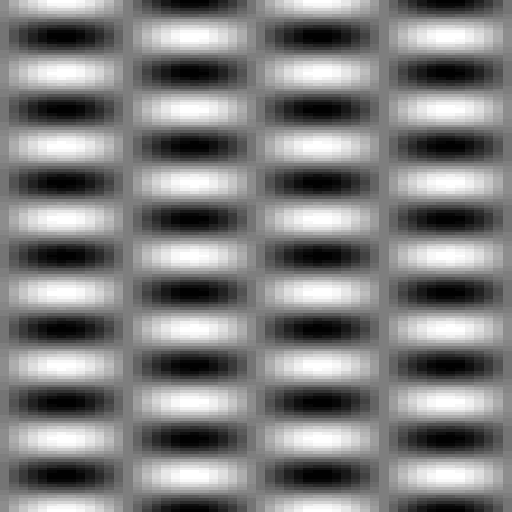

In [ ]:
B_high = 50000
N, b = optimize(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

# 2. Hadamard, Hadamard-Walsh, and Haar matrices

In [ ]:
def plot_functions(A, n, title=""):
  N = 1 << n
  x = np.repeat(np.arange(N + 1), 2)[1:-1] / N
  Y = np.repeat(A(n) * sqrt(N), 2, axis=1)
  colors = plt.cm.get_cmap("hsv", N)
  if title:
    plt.title(f"{title}: n = {n}")
  plt.xlim([-0.05, 1.05])
  plt.ylim([min(np.min(Y) * 1.5, 0), max(np.max(Y) * 1.5, 0)])
  for i in range(N):
    # plt.plot(x, Y[i], color=colors(i))
    plt.plot(x, Y[i], color=(np.random.random(), np.random.random(), np.random.random()))
  plt.show()

## Hadamard Matrices

Implement a Hadamard Matrix of size 2^n.

In [ ]:
def H(n):
  a = np.ones((1, 1), dtype=np.int8)
  for i in range(n):
    a = np.block([[a, a], [a, -a]])
  return a / np.linalg.norm(a, axis=1)

In [ ]:
H(2)

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5]])

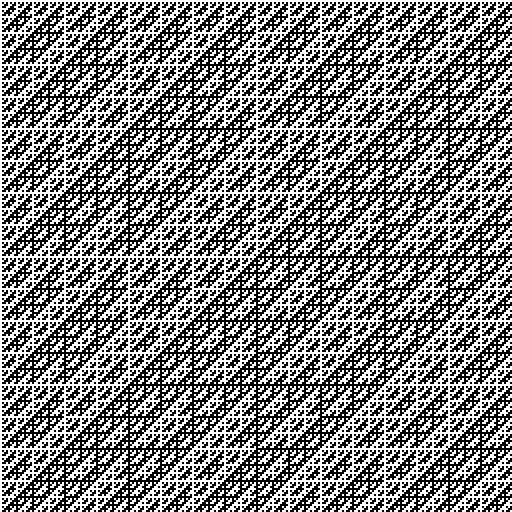

In [ ]:
array_to_image(H(8))

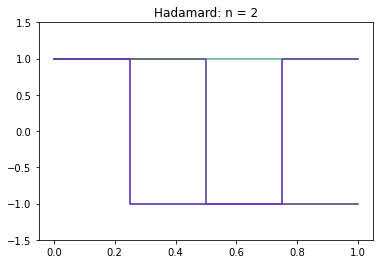

In [ ]:
plot_functions(H, 2, "Hadamard")

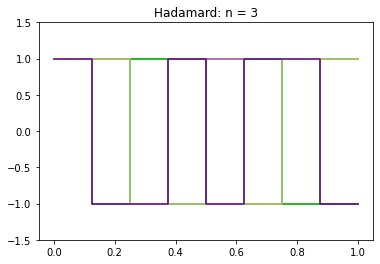

In [ ]:
plot_functions(H, 3, "Hadamard")

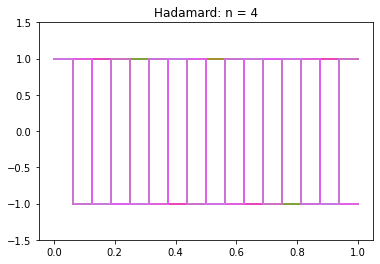

In [ ]:
plot_functions(H, 4, "Hadamard")

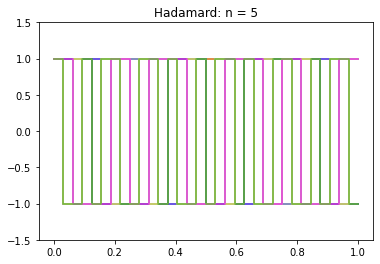

In [ ]:
plot_functions(H, 5, "Hadamard")

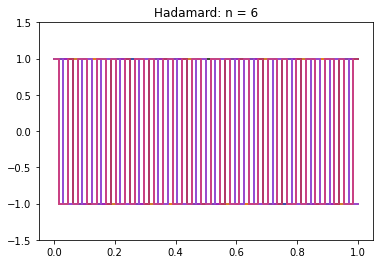

In [ ]:
plot_functions(H, 6, "Hadamard")

## Walsh-Hadamard Matrices

Implement a Walsh-Hadamard Matrix of size 2^n.

In [ ]:
def W(n):
  a = np.ones((1, 1), dtype=np.int8)
  b = np.zeros(1, dtype=np.int64)
  for i in range(n):
    a = np.block([[a, a], [a, -a]])
    b = np.block([b * 2 + (b & 1), b * 2 + (b & 1) ^ 1])
  a = a[b.argsort()]
  return a / np.linalg.norm(a, axis=1)

In [ ]:
W(2)

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5]])

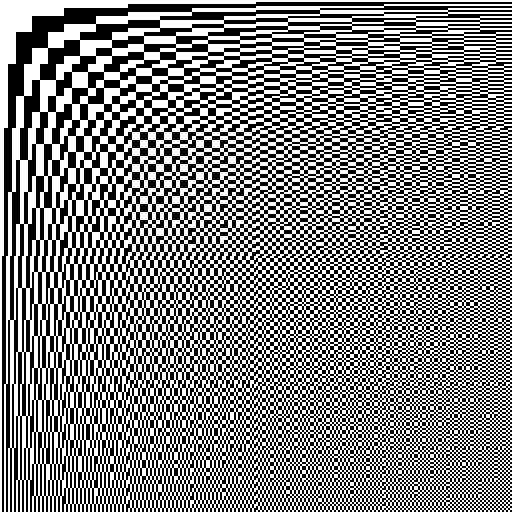

In [ ]:
array_to_image(W(8))

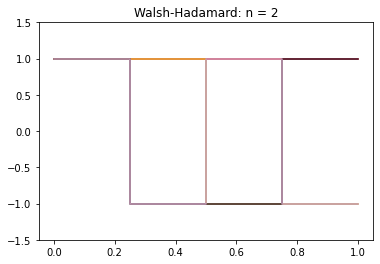

In [ ]:
plot_functions(W, 2, "Walsh-Hadamard")

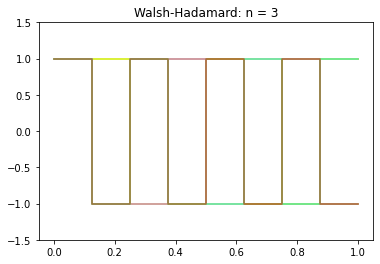

In [ ]:
plot_functions(W, 3, "Walsh-Hadamard")

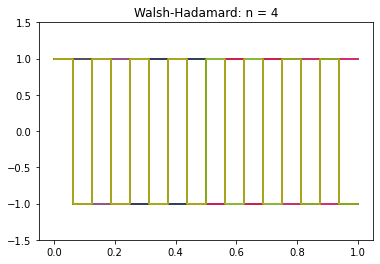

In [ ]:
plot_functions(W, 4, "Walsh-Hadamard")

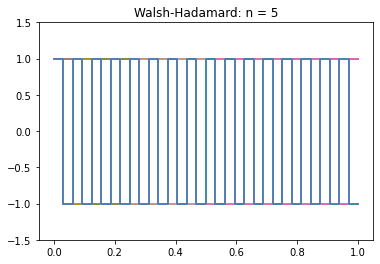

In [ ]:
plot_functions(W, 5, "Walsh-Hadamard")

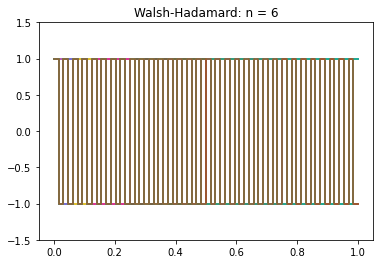

In [ ]:
plot_functions(W, 6, "Walsh-Hadamard")

## Haar Matrices

Implement a Haar Matrix of size 2^n.

In [ ]:
def R(n):
  a = np.ones((1, 1), dtype=np.int8)
  for i in range(n):
    a = np.block([np.kron(a, np.array([[1, 1]]).T), np.kron(np.eye(a.shape[0]), np.array([[1, -1]]).T)])
  return a / np.linalg.norm(a, axis=0)

In [ ]:
R(2)

array([[ 0.5       ,  0.5       ,  0.70710678,  0.        ],
       [ 0.5       ,  0.5       , -0.70710678, -0.        ],
       [ 0.5       , -0.5       ,  0.        ,  0.70710678],
       [ 0.5       , -0.5       , -0.        , -0.70710678]])

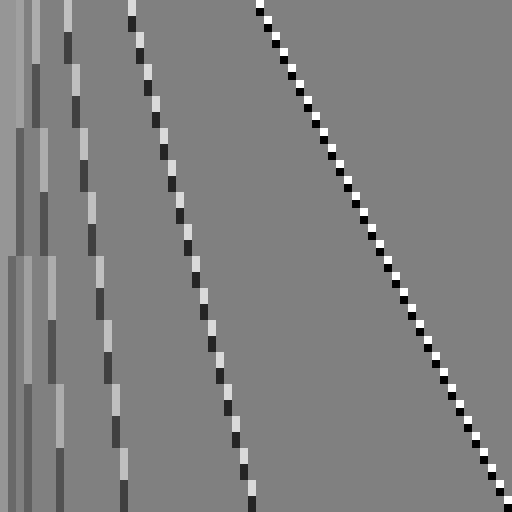

In [ ]:
array_to_image(R(6))

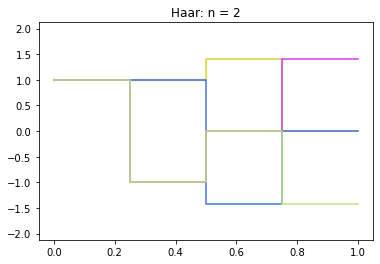

In [ ]:
plot_functions(R, 2, "Haar")

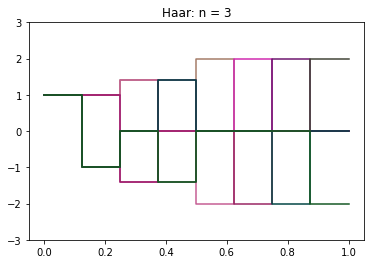

In [ ]:
plot_functions(R, 3, "Haar")

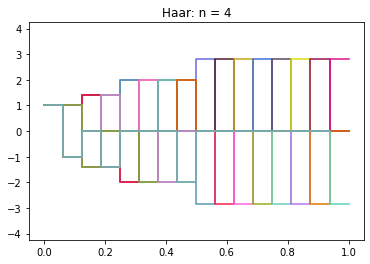

In [ ]:
plot_functions(R, 4, "Haar")

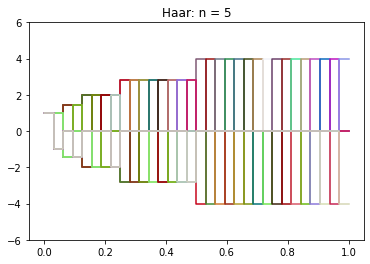

In [ ]:
plot_functions(R, 5, "Haar")

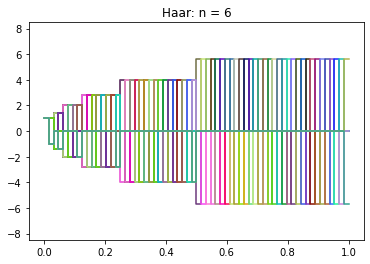

In [ ]:
plot_functions(R, 6, "Haar")

## Application

In [ ]:
def plot(vector, start=-4, end=5, title=""):
  d = (end - start) / vector.shape[0]
  x = np.repeat(np.arange(start, end + d, d), 2)[1:-1]
  y = np.repeat(vector, 2)
  if title:
    plt.title(title)
  plt.plot(x, y)
  plt.show()

In [ ]:
def kApproximate(integral, basis, start=-4, end=5, k=None):
  """Perform k-term approximation of f between a and b using orthonormal basis A"""
  n = basis.shape[0]
  if k is None:
    k = n
  d = (end - start) / n  # size of each interval
  j = np.arange(start, end, d)  # vector of interval boundaries
  f = np.vectorize(integral)
  c = basis @ ((f(j + d) - f(j)) / d)  # coefficient vector
  c = c * (np.argsort(np.argsort(-np.abs(c))) < k)  # eliminate all but the k largest
  return c @ basis

In [ ]:
def calculateMSE(integral, integralSquare, approx, start=-4, end=5):
  """Calculate the mean square error of the approximation of f between a and b"""
  d = (end - start) / approx.shape[0]
  j = np.arange(start, end, d)
  f = np.vectorize(integral); g = np.vectorize(integralSquare)
  e = (g(j + d) - g(j)) - 2 * approx * (f(j + d) - f(j)) + np.square(approx) * d
  return np.sum(e)

Given t ∈ [−4, 5], consider a function

    φ(t) = t * exp(t)

In [ ]:
phi = lambda t: t * exp(t)
integralPhi = lambda t: (t - 1) * exp(t)  # integral of phi(t)
integralPhiSquare = lambda t: (2 * t * t - 2 * t + 1) * exp(2 * t) / 4  # integral of phi^2(t)

Consider n = 2, what are the best k-term approximation of φ(t) for k = 1, ..., 2n in
each basis? Present the results on a graph. What are the corresponding MSE errors?

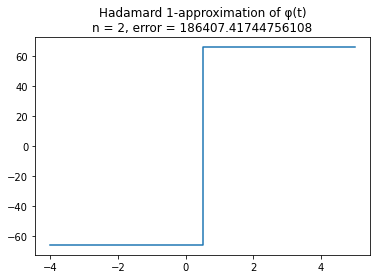

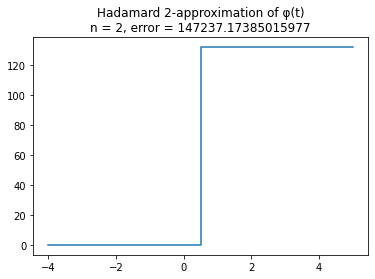

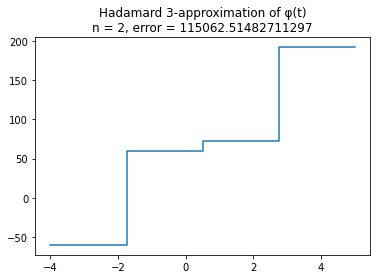

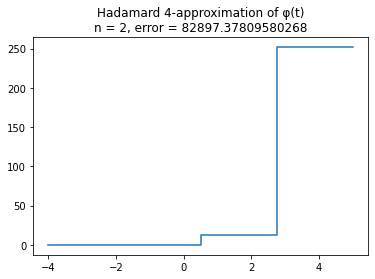

In [ ]:
basis = H(2)
for k in range(1, len(basis) + 1):
  approx = kApproximate(integralPhi, basis, k=k)
  error = calculateMSE(integralPhi, integralPhiSquare, approx)
  plot(approx, title=f"Hadamard {k}-approximation of φ(t)\nn = {2}, error = {error}")

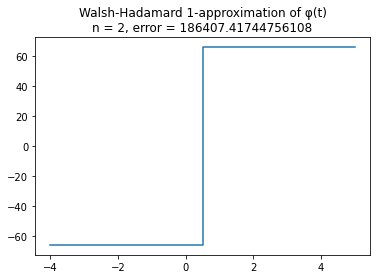

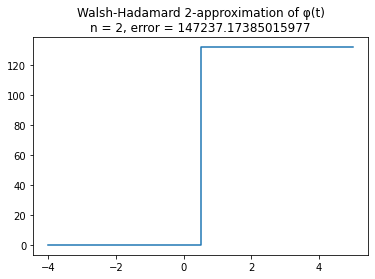

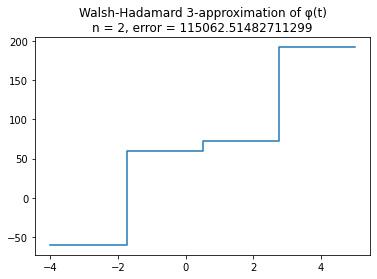

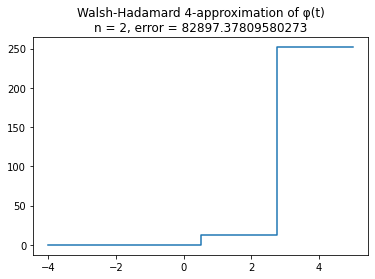

In [ ]:
basis = W(2)
for k in range(1, len(basis) + 1):
  approx = kApproximate(integralPhi, basis, k=k)
  error = calculateMSE(integralPhi, integralPhiSquare, approx)
  plot(approx, title=f"Walsh-Hadamard {k}-approximation of φ(t)\nn = {2}, error = {error}")

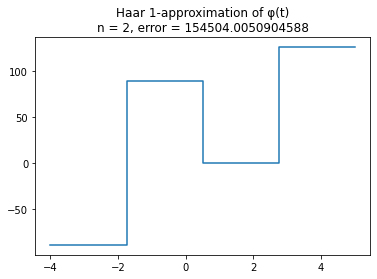

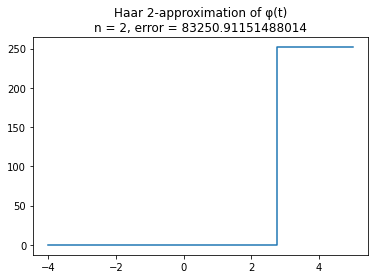

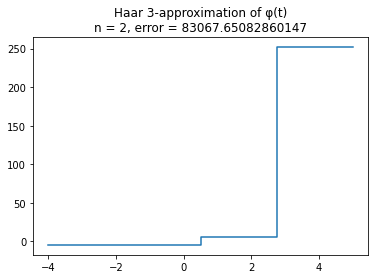

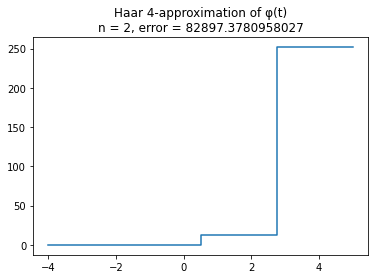

In [ ]:
basis = R(2)
for k in range(1, len(basis) + 1):
  approx = kApproximate(integralPhi, basis, k=k)
  error = calculateMSE(integralPhi, integralPhiSquare, approx)
  plot(approx, title=f"Haar {k}-approximation of φ(t)\nn = {2}, error = {error}")

In [ ]:
from math import sin, cos, pi, sqrt, log, exp, ceil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
def array_to_image(a, size=512):
  """Utility function for printing an array as an image"""
  return Image.fromarray(np.clip((a - np.min(a)) / (np.max(a) - np.min(a)) * 256, 1, 255) \
                         .astype(np.uint8)) \
              .resize((size, size), resample=0)

# 1. Numerical and Practical Bit Allocation for Two-Dimensional Signals


Consider a function,

    φ(x, y) = A cos(2πωx) sin(2πωy) for (x, y) ∈ [0, 1] × [0, 1]

In [ ]:
A = 2500
w = np.array((2, 7))
f = lambda x, y: A * cos(2 * pi * w[0] * x) * sin(2 * pi * w[1] * y)

## Theory

Mathematically develop formulas for derivatives and integrals to calculate the value-range, the horizontal-derivative energy and the vertical-derivative energy.

Since the value range of `cos` and `sin` are `[-1, 1]`, the value range of the formula is `[-A, A]` which is size `2A`.

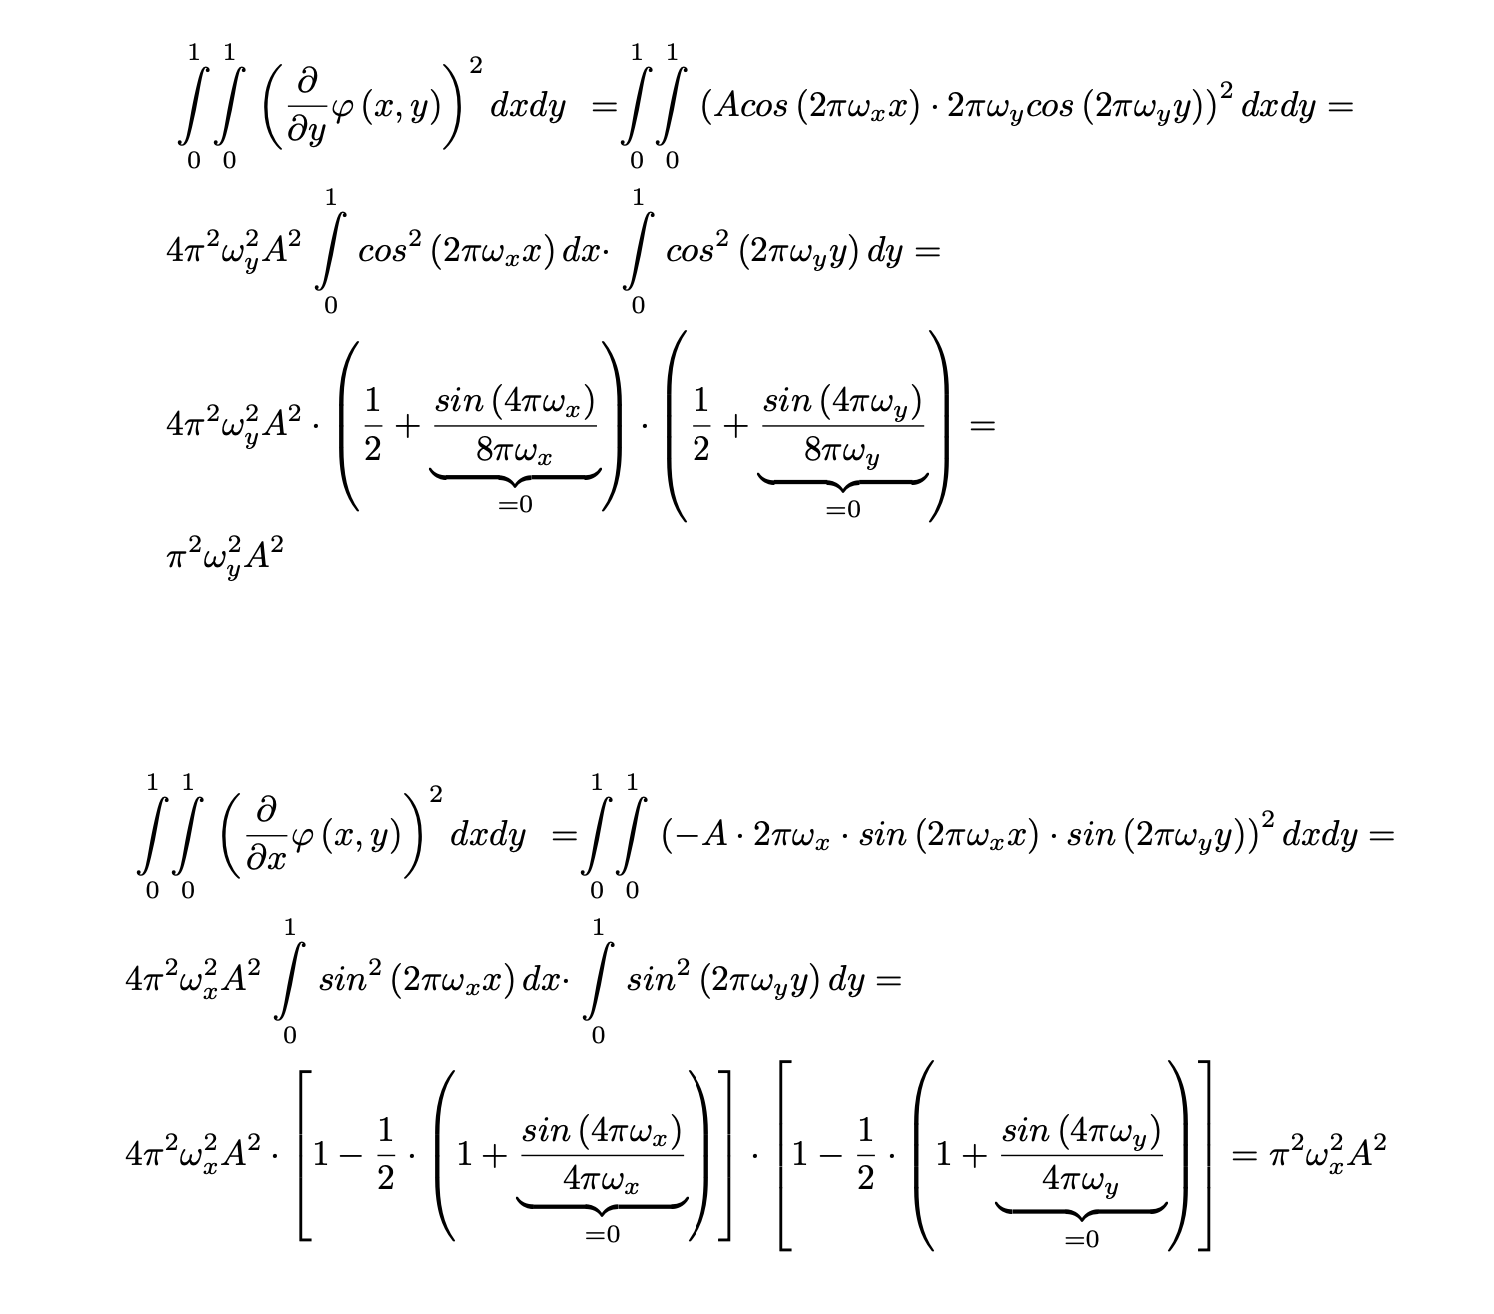

## Application


Approximate the continuous-domain signal φ(x, y) by a very high resolution digitalization. Present the signal as an image using the cv2.imshow function (use an appropriate gray-level scaling that suits the value of A).

In [ ]:
def F(x1, y1, x2, y2):
  """Returns the average value of f(x, y) in a 2-d range (using the integral)"""
  return A / (4 * pi * pi * w[0] * w[1] * (x2 - x1) * (y2 - y1)) \
           * (sin(2 * pi * w[0] * x2) - sin(2 * pi * w[0] * x1)) \
           * (cos(2 * pi * w[1] * y1) - cos(2 * pi * w[1] * y2))

In [ ]:
def sample(integral, shape):
  i, j = np.mgrid[:shape[0], :shape[1]]
  return np.vectorize(integral)(i / shape[0], j / shape[1], (i + 1) / shape[0], (j + 1) / shape[1])

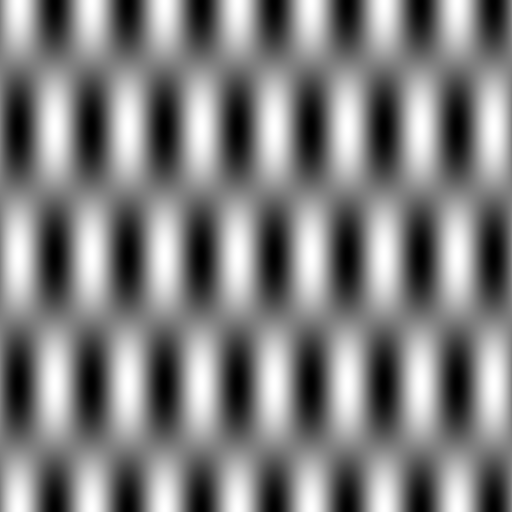

In [ ]:
a = sample(F, (512, 512))
display(array_to_image(a))  # This is better than cv2.imshow

Numerically calculate the value-range, the horizontal-derivative energy and the vertical-derivative energy. Compare these numerical results to the analytically calculated values from the question a.

In [ ]:
vrange = np.max(a) - np.min(a)

energy = np.array((
    np.sum(np.square(np.diff(a, axis=0))) * pow(a.shape[0] / a.shape[1], 2),
    np.sum(np.square(np.diff(a, axis=1))) * pow(a.shape[1] / a.shape[0], 2)
  ))

print(f"Exact value range: {2 * A}")
print(f"Approximate value range: {vrange}\n")

print(f"Exact horizontal-derivative energy: {pow(A * pi * w[0], 2)}")
print(f"Approximate horizontal-derivative energy: {energy[0]}\n")

print(f"Exact vertical-derivative energy: {pow(A * pi * w[1], 2)}")
print(f"Approximate vertical-derivative energy: {energy[1]}")

Exact value range: 5000
Approximate value range: 4997.8668752656495

Exact horizontal-derivative energy: 246740110.02723396
Approximate horizontal-derivative energy: 246563660.2512484

Exact vertical-derivative energy: 3022566347.833616
Approximate vertical-derivative energy: 3006907658.122702


The approximate range is slightly smaller than the exact value because the maxima and minima are smoothed. The same thing can be observed in the derivative energies.

Use the numerical approximations and numerically solve the bit-allocation optimization to determine N_x, N_y and b.

In [ ]:
def allocate(B, vrange, energy):
  b = log(B * vrange * vrange * log(2) / sqrt(np.product(energy)), 4)
  N = np.sqrt((B / b) * np.sqrt(energy / np.flip(energy)))
  return N, b

Consider two bit-allocation procedures with the bit-budgets B_low = 5000 and B_high = 50000. Write the obtained values of N_x, N_y and b.

In [ ]:
def MSE(N, b, vrange, energy):
  return (np.sum(energy / np.square(N)) + (vrange * vrange / pow(4, b))) / 12

In [ ]:
B_low = 5000
N, b = allocate(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}\n")

B_high = 50000
N, b = allocate(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")

Bit allocation for B = 5000:
N_x = 20.74857100903572
N_y = 72.45755960335755
b = 3.3258151716654916
MSE = 116159.30050496734

Bit allocation for B = 50000:
N_x = 53.58301860736825
N_y = 187.12106789332276
b = 4.986779219109173
MSE = 16383.132078008275


## Optimizing Bit-Allocation Parameters

Implement a searching procedure that finds the best bit-allocation parameters by practically evaluating the bit-allocation MSE for many combinations of parameters.

In [ ]:
def optimize(B, vrange, energy, max_step=12):
  """Find the globally optimal bit allocation by taking incrementally growing steps"""
  E = lambda N, b: MSE(N, b, vrange, energy)
  N, b = np.array((1, 1)), 1  # initial guess

  def increment(N, b, d):
    """Find the best bit allocation within Chebyshev distance d"""
    N_next, b_next = N, b
    neighbors = np.reshape(np.transpose(np.mgrid[-d: d + 1, -d: d + 1, -d: d + 1],
                                        (3, 2, 1, 0)), (pow(2 * d + 1, 3), 3))
    neighbors = neighbors[np.max(np.abs(neighbors), axis=1) == d]  # remove already done ones
    for neighbor in neighbors:
      N_try, b_try = np.maximum(N + neighbor[:2], 1), max(b + neighbor[2], 1)
      if (np.product(N_try) * b_try <= B) and E(N_try, b_try) < E(N_next, b_next):
        N_next, b_next = N_try, b_try
    return N_next, b_next

  N_next, b_next = N, b,
  while True:
    step = 1
    while (N_next == N).all() and b_next == b:
      if step > max_step:
        return N, b
      N_next, b_next = increment(N, b, step)
      step += 1
    # print(N_next, b_next, E(N_next, b_next), step - 1)
    N, b = N_next, b_next

Apply the practical searching procedure for two bit-budgets B_low = 5000 and B_high = 50000. For each of the two bit-budgets, what are the optimal values of Nx, Ny and b? Are these similar to the corresponding values from the question e? Explain it in detail. Present the reconstructed images obtained in the experiments.

In [ ]:
B_low = 5000
N, b = optimize(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}\n")

B_high = 50000
N, b = optimize(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")

Bit allocation for B = 5000:
N_x = 21
N_y = 79
b = 3
MSE = 119266.00472091335

Bit allocation for B = 50000:
N_x = 54
N_y = 185
b = 5
MSE = 16400.477354325478


These values are similar but not exactly the same to those found analytically. Because the analytic method is not guaranteed to return an integer, the closest integral solution must have a slightly higher MSE than the ideal.

Reconstruct the image:

In [ ]:
def apply_quantization(array, d, r):
  quantized = np.ones(array.shape) * r[-1]
  for i in range(len(r)):
    quantized[(d[i] <= array) & (array < d[i + 1])] = r[i]
  return quantized

def quantization_error(array, d, r):
  """Calculates the quantization error given the pixel distribution, decision and representation levels."""
  return np.sum(np.square(array - apply_quantization(array, d, r)) / np.product(array.shape))

def uniform_quantization(array, bits):
  """Calculates the decision and representation levels for a uniform quantization using b bits."""
  d = np.arange((1 << bits) + 1) / (1 << bits) * (np.max(array) - np.min(array)) + np.min(array)
  r = (d[:-1] + d[1:]) / 2
  return d, r

def max_lloyd_update(array, d, r):
  """Helper function for Max-Lloyd quantization."""
  r_next = np.empty(r.shape)
  for i in range(len(r)):
    x = array[(d[i] <= array) & (array < d[i + 1])]
    r_next[i] = np.sum(x) / np.product(x.shape) if np.product(x.shape) else (d[i] + d[i + 1]) / 2
  d_next = np.copy(d)
  d_next[1:-1] = (r_next[1:] + r_next[:-1]) / 2
  return d_next, r_next

def max_lloyd_quantization(array, bits, epsilon=0.001):
  """Executes Max-Lloyd quantization algorithm for b bits with a convergence threshold of epsilon."""
  d, r = uniform_quantization(array, bits)  # start with a uniform quantization
  e = quantization_error(array, d, r)
  delta = epsilon
  while abs(delta) >= epsilon:  # loop until difference is less than the threshold
    d, r = max_lloyd_update(array, d, r)  # update decision and representation levels
    delta = e - quantization_error(array, d, r)
    e = e - delta  # recalculate error
  return d, r

def quantize(array, algorithm, bits):
  """Returns a quantized version of the input image using the provided algorithm."""
  d, r = algorithm(array, bits)
  return apply_quantization(array, d, r)

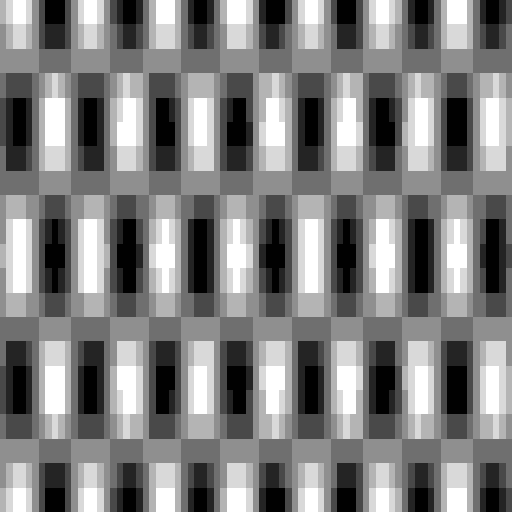

In [ ]:
N, b = optimize(B_low, vrange, energy)
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

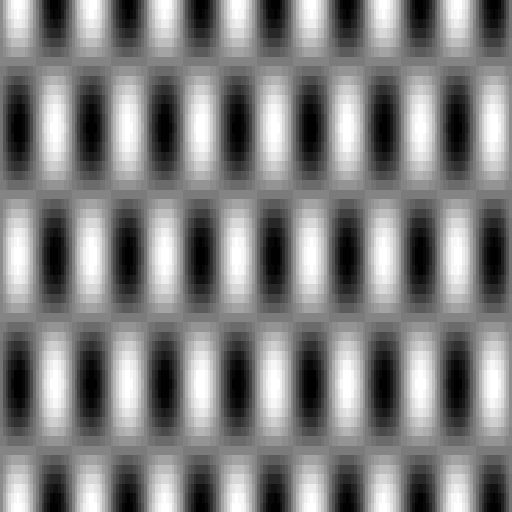

In [ ]:
N, b = optimize(B_high, vrange, energy)
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

## Repeat Analysis for Different Parameters

Consider the same function but with different parameters: A = 2500, ωx = 7 and
ωy = 2. Repeat the analysis from question a to question g and compare the results.
Explain the differences.

As can be seen in the picture and in the results below, every value is the same as in the previous function but where the x and y axes are switched.

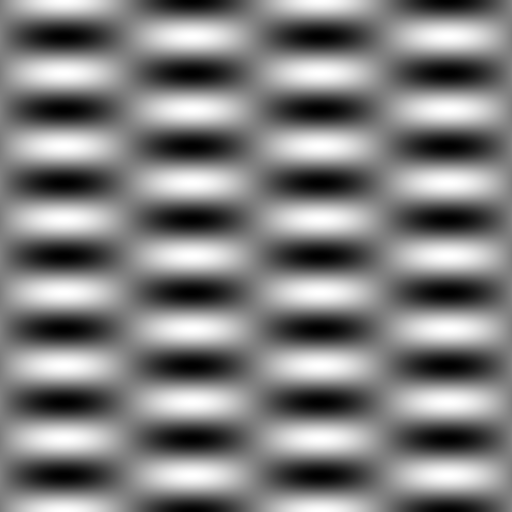

In [ ]:
w = np.array((7, 2))
a = sample(F, (512, 512))
display(array_to_image(a))

In [ ]:
vrange = np.max(a) - np.min(a)

energy = np.array((
    np.sum(np.square(np.diff(a, axis=0))) * pow(a.shape[0] / a.shape[1], 2),
    np.sum(np.square(np.diff(a, axis=1))) * pow(a.shape[1] / a.shape[0], 2)
  ))

print(f"Exact value range: {2 * A}")
print(f"Approximate value range: {vrange}\n")

print(f"Exact horizontal-derivative energy: {pow(A * pi * w[0], 2)}")
print(f"Approximate horizontal-derivative energy: {energy[0]}\n")

print(f"Exact vertical-derivative energy: {pow(A * pi * w[1], 2)}")
print(f"Approximate vertical-derivative energy: {energy[1]}")

Exact value range: 5000
Approximate value range: 4997.86687526565

Exact horizontal-derivative energy: 3022566347.833616
Approximate horizontal-derivative energy: 3018699452.8604403

Exact vertical-derivative energy: 246740110.02723396
Approximate vertical-derivative energy: 245600520.95339188


In [ ]:
B_low = 5000
N, b = allocate(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}\n")

B_high = 50000
N, b = allocate(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")

Bit allocation for B = 5000:
N_x = 72.59949423419609
N_y = 20.708006804041474
b = 3.3258151716654916
MSE = 116159.30050496735

Bit allocation for B = 50000:
N_x = 187.4876129417475
N_y = 53.47826187255247
b = 4.986779219109173
MSE = 16383.13207800828


Bit allocation for B = 5000:
N_x = 79
N_y = 21
b = 3
MSE = 119241.45626823658


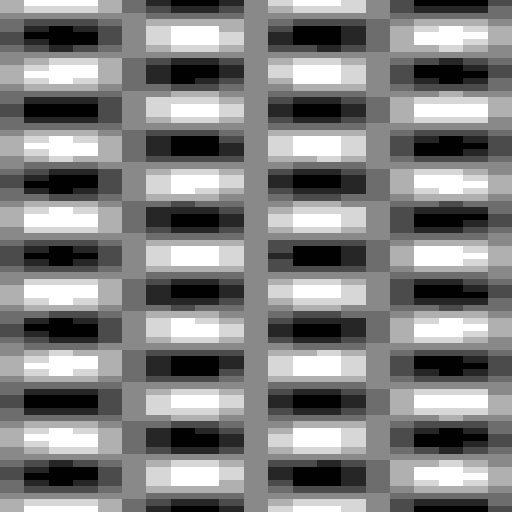

In [ ]:
B_low = 5000
N, b = optimize(B_low, vrange, energy)
print(f"Bit allocation for B = {B_low}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

Bit allocation for B = 50000:
N_x = 185
N_y = 54
b = 5
MSE = 16401.664252757193


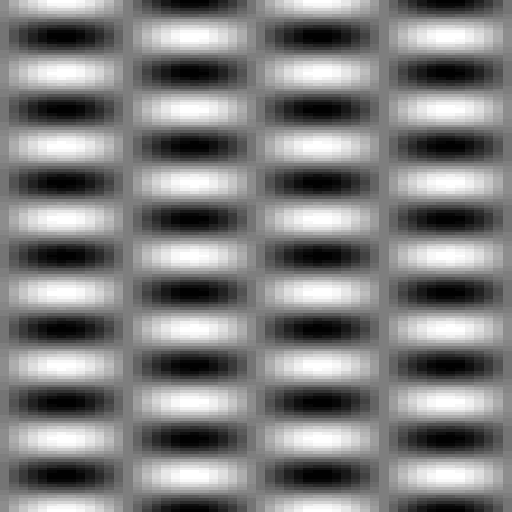

In [ ]:
B_high = 50000
N, b = optimize(B_high, vrange, energy)
print(f"Bit allocation for B = {B_high}:\nN_x = {N[0]}\nN_y = {N[1]}\nb = {b}\nMSE = {MSE(N, b, vrange, energy)}")
display(array_to_image(quantize(sample(F, N), max_lloyd_quantization, b)))

# 2. Hadamard, Hadamard-Walsh, and Haar matrices

In [ ]:
def plot_functions(A, n, title=""):
  N = 1 << n
  x = np.repeat(np.arange(N + 1), 2)[1:-1] / N
  Y = np.repeat(A(n) * sqrt(N), 2, axis=1)
  colors = plt.cm.get_cmap("hsv", N)
  if title:
    plt.title(f"{title}: n = {n}")
  plt.xlim([-0.05, 1.05])
  plt.ylim([min(np.min(Y) * 1.5, 0), max(np.max(Y) * 1.5, 0)])
  for i in range(N):
    # plt.plot(x, Y[i], color=colors(i))
    plt.plot(x, Y[i], color=(np.random.random(), np.random.random(), np.random.random()))
  plt.show()

## Hadamard Matrices

Implement a Hadamard Matrix of size 2^n.

In [ ]:
def H(n):
  a = np.ones((1, 1), dtype=np.int8)
  for i in range(n):
    a = np.block([[a, a], [a, -a]])
  return a / np.linalg.norm(a, axis=1)

In [ ]:
H(2)

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5]])

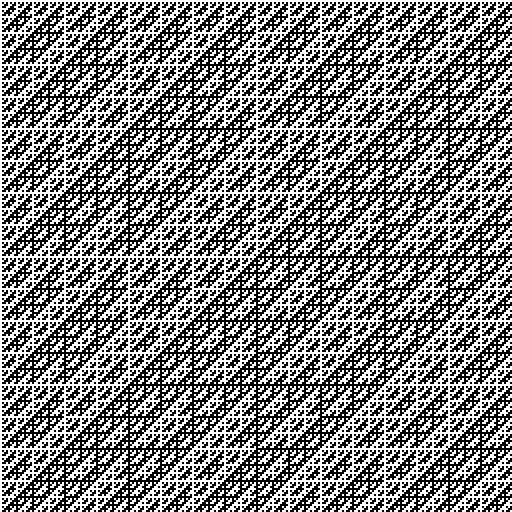

In [ ]:
array_to_image(H(8))

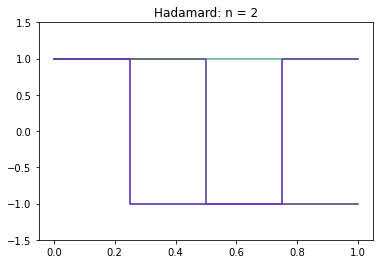

In [ ]:
plot_functions(H, 2, "Hadamard")

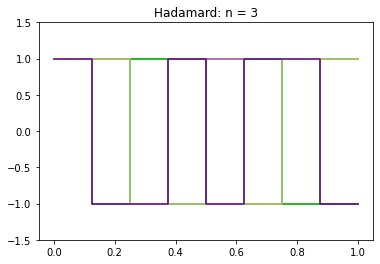

In [ ]:
plot_functions(H, 3, "Hadamard")

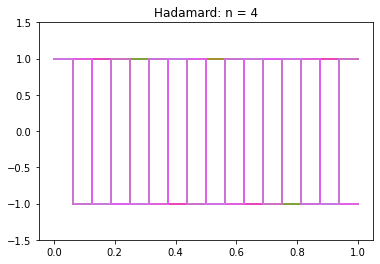

In [ ]:
plot_functions(H, 4, "Hadamard")

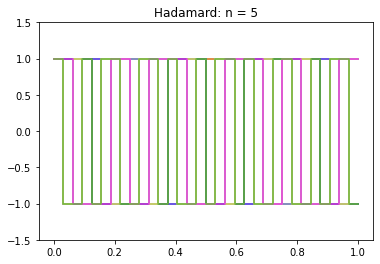

In [ ]:
plot_functions(H, 5, "Hadamard")

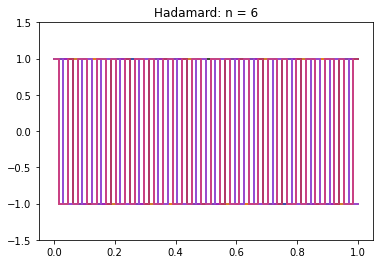

In [ ]:
plot_functions(H, 6, "Hadamard")

## Walsh-Hadamard Matrices

Implement a Walsh-Hadamard Matrix of size 2^n.

In [ ]:
def W(n):
  a = np.ones((1, 1), dtype=np.int8)
  b = np.zeros(1, dtype=np.int64)
  for i in range(n):
    a = np.block([[a, a], [a, -a]])
    b = np.block([b * 2 + (b & 1), b * 2 + (b & 1) ^ 1])
  a = a[b.argsort()]
  return a / np.linalg.norm(a, axis=1)

In [ ]:
W(2)

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5]])

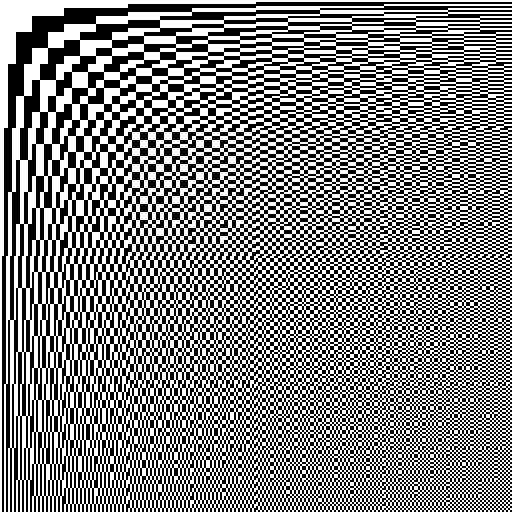

In [ ]:
array_to_image(W(8))

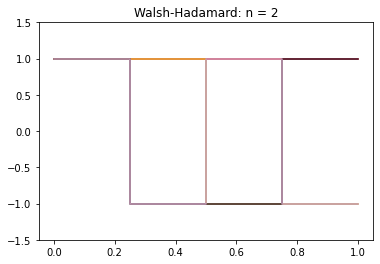

In [ ]:
plot_functions(W, 2, "Walsh-Hadamard")

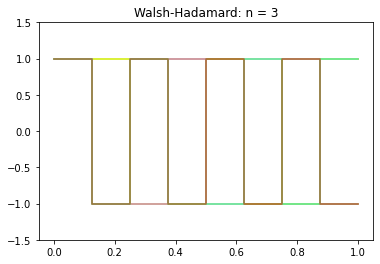

In [ ]:
plot_functions(W, 3, "Walsh-Hadamard")

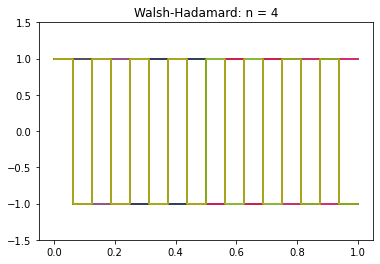

In [ ]:
plot_functions(W, 4, "Walsh-Hadamard")

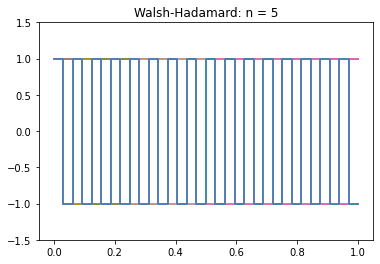

In [ ]:
plot_functions(W, 5, "Walsh-Hadamard")

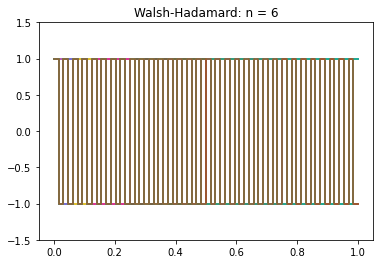

In [ ]:
plot_functions(W, 6, "Walsh-Hadamard")

## Haar Matrices

Implement a Haar Matrix of size 2^n.

In [ ]:
def R(n):
  a = np.ones((1, 1), dtype=np.int8)
  for i in range(n):
    a = np.block([np.kron(a, np.array([[1, 1]]).T), np.kron(np.eye(a.shape[0]), np.array([[1, -1]]).T)])
  return a / np.linalg.norm(a, axis=0)

In [ ]:
R(2)

array([[ 0.5       ,  0.5       ,  0.70710678,  0.        ],
       [ 0.5       ,  0.5       , -0.70710678, -0.        ],
       [ 0.5       , -0.5       ,  0.        ,  0.70710678],
       [ 0.5       , -0.5       , -0.        , -0.70710678]])

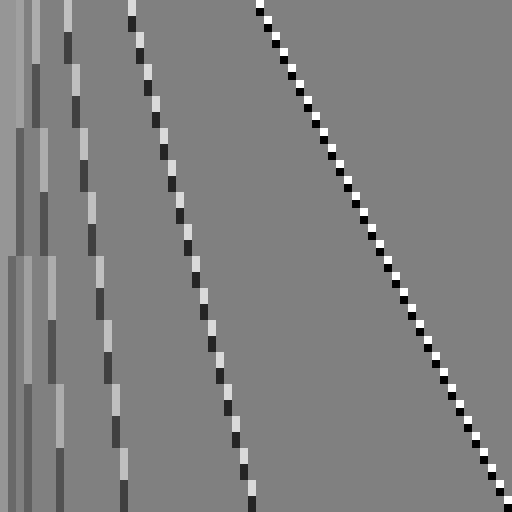

In [ ]:
array_to_image(R(6))

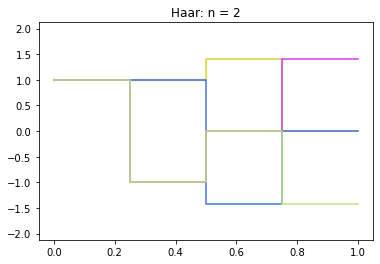

In [ ]:
plot_functions(R, 2, "Haar")

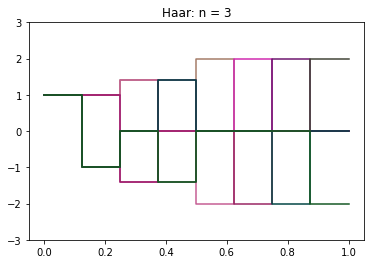

In [ ]:
plot_functions(R, 3, "Haar")

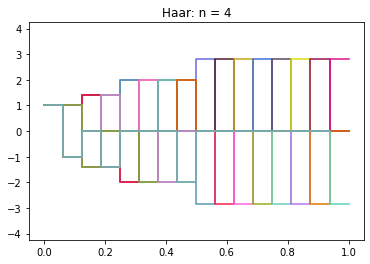

In [ ]:
plot_functions(R, 4, "Haar")

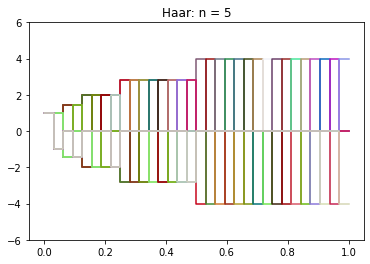

In [ ]:
plot_functions(R, 5, "Haar")

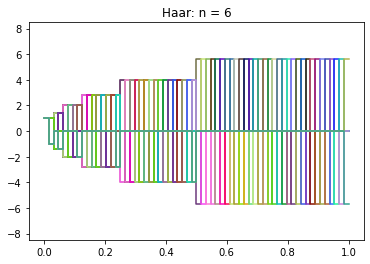

In [ ]:
plot_functions(R, 6, "Haar")

## Application

In [ ]:
def plot(vector, start=-4, end=5, title=""):
  d = (end - start) / vector.shape[0]
  x = np.repeat(np.arange(start, end + d, d), 2)[1:-1]
  y = np.repeat(vector, 2)
  if title:
    plt.title(title)
  plt.plot(x, y)
  plt.show()

In [ ]:
def kApproximate(integral, basis, start=-4, end=5, k=None):
  """Perform k-term approximation of f between a and b using orthonormal basis A"""
  n = basis.shape[0]
  if k is None:
    k = n
  d = (end - start) / n  # size of each interval
  j = np.arange(start, end, d)  # vector of interval boundaries
  f = np.vectorize(integral)
  c = basis @ ((f(j + d) - f(j)) / d)  # coefficient vector
  c = c * (np.argsort(np.argsort(-np.abs(c))) < k)  # eliminate all but the k largest
  return c @ basis

In [ ]:
def calculateMSE(integral, integralSquare, approx, start=-4, end=5):
  """Calculate the mean square error of the approximation of f between a and b"""
  d = (end - start) / approx.shape[0]
  j = np.arange(start, end, d)
  f = np.vectorize(integral); g = np.vectorize(integralSquare)
  e = (g(j + d) - g(j)) - 2 * approx * (f(j + d) - f(j)) + np.square(approx) * d
  return np.sum(e)

Given t ∈ [−4, 5], consider a function

    φ(t) = t * exp(t)

In [ ]:
phi = lambda t: t * exp(t)
integralPhi = lambda t: (t - 1) * exp(t)  # integral of phi(t)
integralPhiSquare = lambda t: (2 * t * t - 2 * t + 1) * exp(2 * t) / 4  # integral of phi^2(t)

Consider n = 2, what are the best k-term approximation of φ(t) for k = 1, ..., 2n in
each basis? Present the results on a graph. What are the corresponding MSE errors?

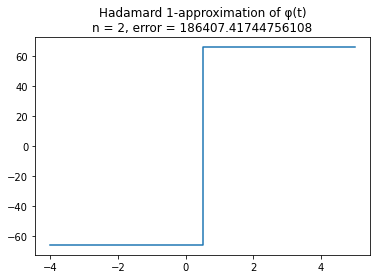

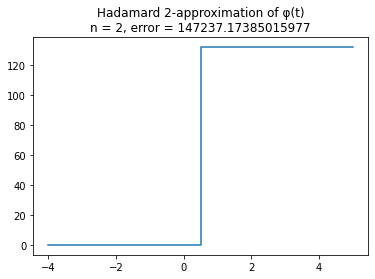

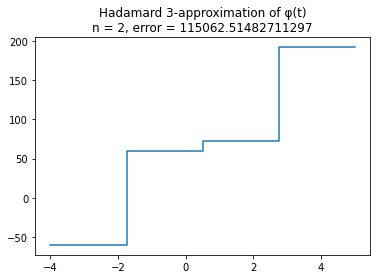

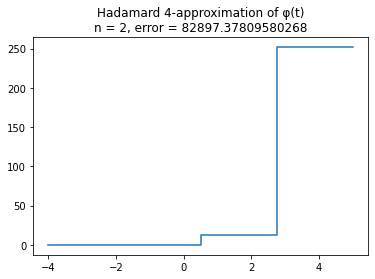

In [ ]:
basis = H(2)
for k in range(1, len(basis) + 1):
  approx = kApproximate(integralPhi, basis, k=k)
  error = calculateMSE(integralPhi, integralPhiSquare, approx)
  plot(approx, title=f"Hadamard {k}-approximation of φ(t)\nn = {2}, error = {error}")

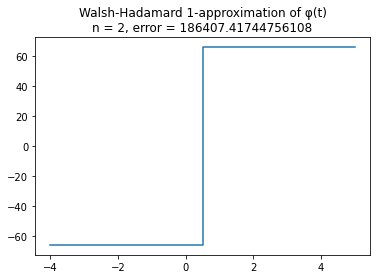

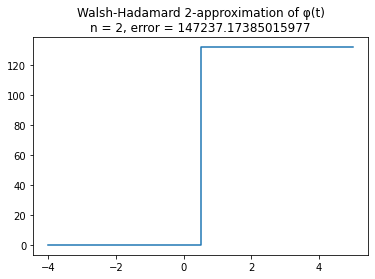

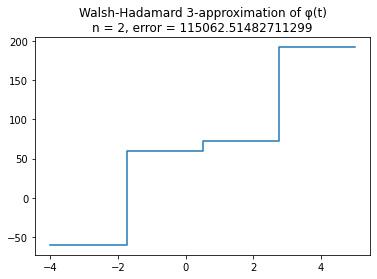

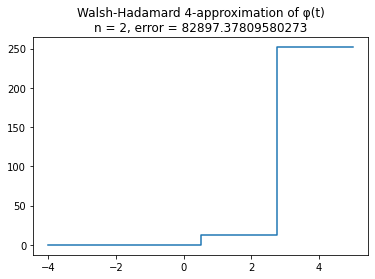

In [ ]:
basis = W(2)
for k in range(1, len(basis) + 1):
  approx = kApproximate(integralPhi, basis, k=k)
  error = calculateMSE(integralPhi, integralPhiSquare, approx)
  plot(approx, title=f"Walsh-Hadamard {k}-approximation of φ(t)\nn = {2}, error = {error}")

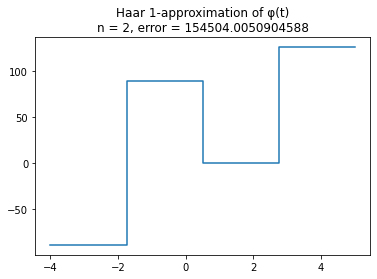

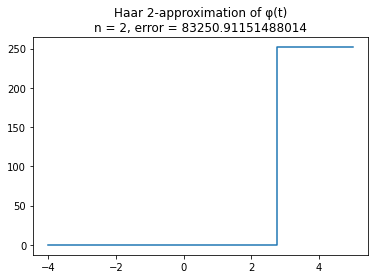

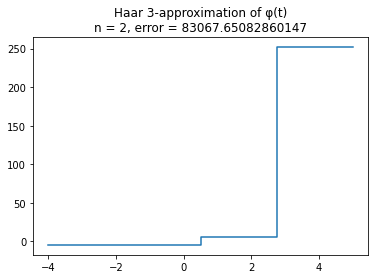

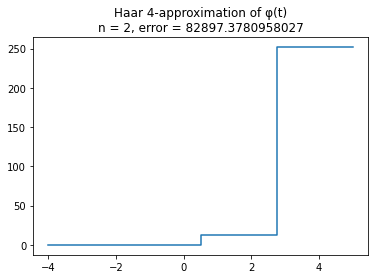

In [ ]:
basis = R(2)
for k in range(1, len(basis) + 1):
  approx = kApproximate(integralPhi, basis, k=k)
  error = calculateMSE(integralPhi, integralPhiSquare, approx)
  plot(approx, title=f"Haar {k}-approximation of φ(t)\nn = {2}, error = {error}")